In [12]:
# import libraries and mount to google drive
import sys
import os
import csv
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# set up DEVICE and import data
DEBUG = True
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() and not DEBUG else 'cpu'

mini_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/mini.csv')
mini2_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/mini2.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/train.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/test.csv')

input_file = '/content/drive/MyDrive/Math_Thesis/train.csv'

In [14]:
# Add the OptionDataset class definition
class OptionDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.data.iloc[idx]
        if self.transform:
            row = self.transform(row)
        return row


def get_device():
    if torch.cuda.is_available() and not debug:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')  # don't have GPU
    return device


def init_weights(m):
    print(m)

# Add the parse_data function
def import_data(input_file, device='cpu', split=False):
    input_df = np.array((list(csv.reader(open(input_file, "r"))))[1:], dtype=object)

    size_train = len(input_df)

    ml_th = 0.52
    tp = 0
    tn = 0
    ps = 0

    min_norm = 10000.0
    max_norm = -10000.0

    for i in range(len(input_df)):
        for j in range(4, 23):
            input_df[i][j] = float(input_df[i][j])
        # label
        real0 = (input_df[i][6] + input_df[i][9]) / 2
        label = 1 if input_df[i][17] >= real0 - 0.000000001 else 0

        forecast = 1 if input_df[i][15] >= real0 - 0.000000001 else 0
        input_df[i][3] = forecast
        input_df[i][1] = input_df[i][17] / real0 - 1.0  # RoI
        input_df[i][17] = label
        ps += forecast

        if forecast == 1 and label == 1:
            tp += 1
        elif forecast == 0 and label == 0:
            tn += 1
        # normalization
        # print(input_df[i][0])
        strike = float(input_df[i][0].split(' ')[-2][1:])
        s_ask = input_df[i][10] - strike
        s_bid = input_df[i][11] - strike
        s = (input_df[i][10] + input_df[i][11]) / 2
        norm = (s - strike) / (s + strike)
        if norm > max_norm:
            max_norm = norm
        if norm < min_norm:
            min_norm = norm
        input_df[i][2] = norm

        total = 0.0
        for j in range(4, 10):
            total += input_df[i][j]
        av = total / 6.0
        sigma = 0.0
        for j in range(4, 10):
            sigma += (input_df[i][j] - av) ** 2
        sigma = math.sqrt(sigma / 5.0)
        for j in range(4, 10):
            input_df[i][j] = (input_df[i][j] - av) / sigma
        input_df[i][10] = (s_ask - av) / sigma
        input_df[i][11] = (s_bid - av) / sigma
        input_df[i][15] = (input_df[i][15] - av) / sigma
        input_df[i][16] = (input_df[i][16] - av) / sigma
        # print(input_df[i])

    x = torch.Tensor(input_df[0:size_train, 4:17].astype(float)).float().to(device)
    # print(x)
    y = torch.from_numpy(input_df[0:size_train, 17:18].astype(float)).float().to(device)

    if split:
        x_train, x_val, x_test, y_train, y_val, y_test = data_split(x, y)
        x_train = x_train.reshape((1, x_train.shape[0], x_train.shape[1]))
        x_val = x_val.reshape((1, x_val.shape[0], x_val.shape[1]))
        x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1]))
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        x = x.reshape((1, x.shape[0], x.shape[1]))
        return x, y


def data_split(x, y):
    n = len(y)
    random_indices = torch.randperm(n)
    num_train = int(n * 0.7)
    num_val = int(n * 0.2)

    x_train = x[random_indices[:num_train]]
    y_train = y[random_indices[:num_train]]
    x_val = x[random_indices[num_train:num_train + num_val]]
    y_val = y[random_indices[num_train:num_train + num_val]]
    x_test = x[random_indices[num_train + num_val:]]
    y_test = y[random_indices[num_train + num_val:]]
    return x_train, x_val, x_test, y_train, y_val, y_test



x, y = import_data(input_file)
print(x.shape)  # torch.Size([70322, 11, 13])
print(y.shape)  # torch.Size([70322, 1])
print(y[:10])




torch.Size([1, 70322, 13])
torch.Size([70322, 1])
tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.]])


In [15]:
# CNN Model Class
class CNNModel(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv2 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv3 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv4 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv5 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.pool = nn.MaxPool1d(1, 3)
        self.sigmoid = nn.Sigmoid()
        self.to(device)


    def forward(self, x):
        dropped_one, n, d = x.shape
        x = x.reshape((1, 1, n, d))
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        x = self.conv5(x)
        dopped_one_1, dropped_one_2, n, d = x.shape
        x = x.reshape((1, n, d))
        x = self.pool(x)
        # print(x.shape)
        x = self.sigmoid(x)
        return x

In [16]:
def train(model, x_train, y_train, n_epochs=5, lr=0.0001):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    losses = []
    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()

        output_train = model(x_train)
        output_train = output_train.reshape((output_train.shape[1], output_train.shape[2]))
        # print(output_train)
        loss_train = criterion(output_train, y_train)
        loss_train.backward()
        optimizer.step()
        loss_value = loss_train.item()
        losses.append(loss_value)
        if epoch % 100 == 0:
            print("Epoch {}: loss = {}".format(str(epoch), str(loss_value)))

        if len(output_train.nonzero()) == 0:        # not sure if this works
            print("Epoch {}: all zero output!".format(str(epoch)))

    return losses

def calc_acc(y_pred, y, th=0.52):
    #tp = 0
    #tn = 0
    size = len(y)
    #for i in range(size):
    #    if y_pred[i] >= th and y[i] == 1:
    #        tp += 1
    #    elif y_pred[i] < th and y[i] == 0:
    #        tn += 1
    #return float(tp + tn)*100/size
    with torch.no_grad():
        #print(y)
        #print(y_pred)
        y_th = torch.heaviside(y_pred - torch.tensor(th).expand_as(y_pred), torch.tensor(1.0).expand_as(y_pred))
        tp = torch.sum(torch.logical_and(y_th, y))
        p_pred = torch.sum(y_th)
        p_label = torch.sum(y)
        #print(y_th)
        #print(torch.logical_xor(y_th, y))
        acc = float(size - torch.sum(torch.logical_xor(y_th, y)))*100/size
        prec = float(tp)*100/p_pred
        rec = float(tp)*100/p_label
    return [acc, prec, rec]


In [17]:
# Splitting Data for Training
DEVICE = get_device()

TRAIN_INPUT_FILE = '/content/drive/MyDrive/Math_Thesis/train.csv'
TEST_INPUT_FILE = '/content/drive/MyDrive/Math_Thesis/test.csv'
VAL_INPUT_FILE = '/content/drive/MyDrive/Math_Thesis/valid.csv'

x_train, y_train = import_data(TRAIN_INPUT_FILE, DEVICE)
x_test, y_test = import_data(TEST_INPUT_FILE, DEVICE)
x_val, y_val = import_data(VAL_INPUT_FILE, DEVICE)
model = CNNModel()
print("input shape" + str(x_train.shape))
test_output = model(x_train)
print("output shape" + str(test_output.shape))
# print(test_output)


print("Importing Data...")
x_train, y_train = import_data(TRAIN_INPUT_FILE)


print(x_train.shape)
print(y_train.shape)

input shapetorch.Size([1, 70322, 13])
output shapetorch.Size([1, 70322, 1])
Importing Data...
torch.Size([1, 70322, 13])
torch.Size([70322, 1])


In [18]:
# CNN Training
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


model = CNNModel(DEVICE)
losses = train(model, x_train, y_train, n_epochs=100, lr=0.001)

  1%|          | 1/100 [00:00<00:49,  2.01it/s]

Epoch 0: loss = 0.9187731146812439


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


Text(0, 0.5, 'Loss')

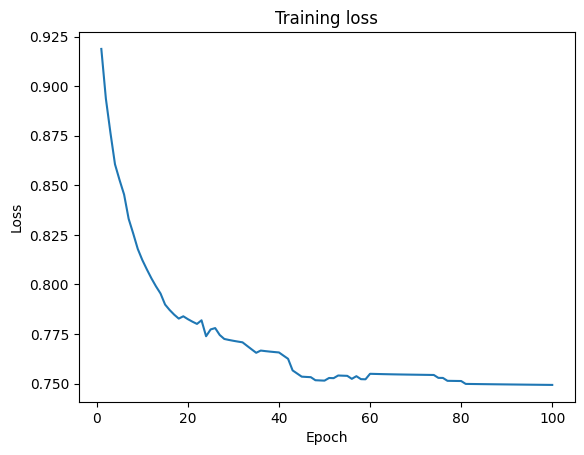

In [19]:
# print loss visualization
# print(losses)
# plot
plot_x = np.arange(1, 101)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [20]:
# Hyperparameter tuning
print("Hyperparameter tuning")
best_th = 0.0
best_acc = 0.0
with torch.no_grad():
    for i in range(100):
        th = i / 100.0
        y_prediction = model(x_val)
        y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
        evauluation_result = calc_acc(y_prediction, y_val, th=th)
        accuracy = evauluation_result[0]
        if accuracy > best_acc:
            best_acc = accuracy
            best_th = th
    print("best threshold:" + str(best_th))
    print(best_acc)

Hyperparameter tuning
best threshold:0.51
52.40506329113924


In [21]:
# evaluation on training data
print("Evaluate on training data with best threshold")
with torch.no_grad():
    y_prediction = model(x_train)
    y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
    evaluation_result = calc_acc(y_prediction, y_train)
    print(evaluation_result)

Evaluate on training data with best threshold
[52.59520491453599, tensor(55.9269), tensor(40.0110)]


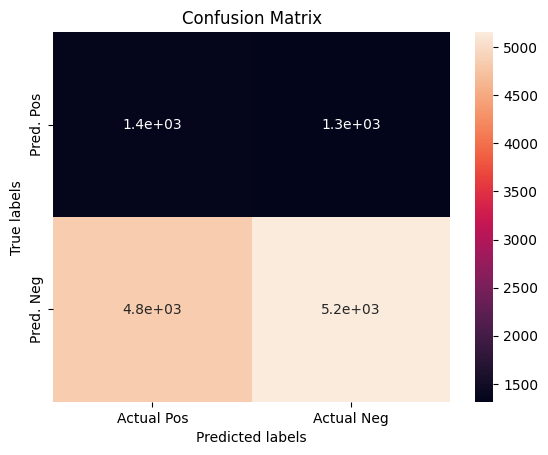

In [22]:
# plot confusion matrix
# confusion matrix
# Confusion Matrix on submission_model_XX
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg'])

def plot_model(model_name, predictions, labels):
    y_true = labels
    y_pred = predictions
    x = confusion_matrix(y_true, y_pred)
    tp = x[1][1]
    fp = x[0][1]
    tn = x[0][0]
    fn = x[1][0]
    ax= plt.subplot()
    plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix' + model_name)

with torch.no_grad():
    y_prediction = model(x_test)
    y_prediction_confusion = y_prediction.reshape(y_prediction.shape[1])
    y_th = torch.heaviside(y_prediction_confusion
                           - torch.tensor(best_th).expand_as(y_prediction_confusion),
                           torch.tensor(1.0).expand_as(y_prediction_confusion))
    y_test_confusion = y_test.reshape(y_test.shape[0])
    plot_model("", y_th, y_test_confusion)

In [23]:
# evaluation 
print("Evaluate on testing data with best threshold")
with torch.no_grad():
    y_prediction = model(x_test)
    y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
    evaluation_result = calc_acc(y_prediction, y_test, th=best_th)
    print(evaluation_result)

Evaluate on testing data with best threshold
[51.45861332911693, tensor(50.7312), tensor(21.8967)]


In [24]:
# all CNN + import data as one
'''
import sys
import os
import csv
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')


DEBUG = True
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() and not DEBUG else 'cpu'

mini_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/mini.csv')
mini2_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/mini2.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/train.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Math_Thesis/test.csv')

input_file = train_data

# Add the OptionDataset class definition

class OptionDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.data.iloc[idx]
        if self.transform:
            row = self.transform(row)
        return row


def get_device():
    if torch.cuda.is_available() and not debug:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')  # don't have GPU
    return device


def init_weights(m):
    print(m)

# Add the parse_data function
def import_data(input_file, device='cpu', split=False):
    input_df = np.array((list(csv.reader(open(input_file, "r"))))[1:], dtype=object)

    size_train = len(input_df)

    ml_th = 0.52
    tp = 0
    tn = 0
    ps = 0

    min_norm = 10000.0
    max_norm = -10000.0

    for i in range(len(input_df)):
        for j in range(4, 23):
            input_df[i][j] = float(input_df[i][j])
        # label
        real0 = (input_df[i][6] + input_df[i][9]) / 2
        label = 1 if input_df[i][17] >= real0 - 0.000000001 else 0

        forecast = 1 if input_df[i][15] >= real0 - 0.000000001 else 0
        input_df[i][3] = forecast
        input_df[i][1] = input_df[i][17] / real0 - 1.0  # RoI
        input_df[i][17] = label
        ps += forecast

        if forecast == 1 and label == 1:
            tp += 1
        elif forecast == 0 and label == 0:
            tn += 1
        # normalization
        # print(input_df[i][0])
        strike = float(input_df[i][0].split(' ')[-2][1:])
        s_ask = input_df[i][10] - strike
        s_bid = input_df[i][11] - strike
        s = (input_df[i][10] + input_df[i][11]) / 2
        norm = (s - strike) / (s + strike)
        if norm > max_norm:
            max_norm = norm
        if norm < min_norm:
            min_norm = norm
        input_df[i][2] = norm

        total = 0.0
        for j in range(4, 10):
            total += input_df[i][j]
        av = total / 6.0
        sigma = 0.0
        for j in range(4, 10):
            sigma += (input_df[i][j] - av) ** 2
        sigma = math.sqrt(sigma / 5.0)
        for j in range(4, 10):
            input_df[i][j] = (input_df[i][j] - av) / sigma
        input_df[i][10] = (s_ask - av) / sigma
        input_df[i][11] = (s_bid - av) / sigma
        input_df[i][15] = (input_df[i][15] - av) / sigma
        input_df[i][16] = (input_df[i][16] - av) / sigma
        # print(input_df[i])

    x = torch.Tensor(input_df[0:size_train, 4:17].astype(float)).float().to(device)
    # print(x)
    y = torch.from_numpy(input_df[0:size_train, 17:18].astype(float)).float().to(device)

    if split:
        x_train, x_val, x_test, y_train, y_val, y_test = data_split(x, y)
        x_train = x_train.reshape((1, x_train.shape[0], x_train.shape[1]))
        x_val = x_val.reshape((1, x_val.shape[0], x_val.shape[1]))
        x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1]))
        return x_train, x_val, x_test, y_train, y_val, y_test
    else:
        x = x.reshape((1, x.shape[0], x.shape[1]))
        return x, y


def data_split(x, y):
    n = len(y)
    random_indices = torch.randperm(n)
    num_train = int(n * 0.7)
    num_val = int(n * 0.2)

    x_train = x[random_indices[:num_train]]
    y_train = y[random_indices[:num_train]]
    x_val = x[random_indices[num_train:num_train + num_val]]
    y_val = y[random_indices[num_train:num_train + num_val]]
    x_test = x[random_indices[num_train + num_val:]]
    y_test = y[random_indices[num_train + num_val:]]
    return x_train, x_val, x_test, y_train, y_val, y_test


input_file = '/content/drive/MyDrive/Math_Thesis/train.csv'
x, y = import_data(input_file)
print(x.shape)  # torch.Size([70322, 11, 13])
print(y.shape)  # torch.Size([70322, 1])
print(y[:10])





class CNNModel(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv2 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv3 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv4 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv5 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.pool = nn.MaxPool1d(1, 3)
        self.sigmoid = nn.Sigmoid()
        self.to(device)


    def forward(self, x):
        dropped_one, n, d = x.shape
        x = x.reshape((1, 1, n, d))
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        x = self.conv5(x)
        dopped_one_1, dropped_one_2, n, d = x.shape
        x = x.reshape((1, n, d))
        x = self.pool(x)
        # print(x.shape)
        x = self.sigmoid(x)
        return x

def train(model, x_train, y_train, n_epochs=5, lr=0.0001):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    losses = []
    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()

        output_train = model(x_train)
        output_train = output_train.reshape((output_train.shape[1], output_train.shape[2]))
        # print(output_train)
        loss_train = criterion(output_train, y_train)
        loss_train.backward()
        optimizer.step()
        loss_value = loss_train.item()
        losses.append(loss_value)
        if epoch % 100 == 0:
            print("Epoch {}: loss = {}".format(str(epoch), str(loss_value)))

        if len(output_train.nonzero()) == 0:        # not sure if this works
            print("Epoch {}: all zero output!".format(str(epoch)))

    return losses

def calc_acc(y_pred, y, th=0.52):
    #tp = 0
    #tn = 0
    size = len(y)
    #for i in range(size):
    #    if y_pred[i] >= th and y[i] == 1:
    #        tp += 1
    #    elif y_pred[i] < th and y[i] == 0:
    #        tn += 1
    #return float(tp + tn)*100/size
    with torch.no_grad():
        #print(y)
        #print(y_pred)
        y_th = torch.heaviside(y_pred - torch.tensor(th).expand_as(y_pred), torch.tensor(1.0).expand_as(y_pred))
        tp = torch.sum(torch.logical_and(y_th, y))
        p_pred = torch.sum(y_th)
        p_label = torch.sum(y)
        #print(y_th)
        #print(torch.logical_xor(y_th, y))
        acc = float(size - torch.sum(torch.logical_xor(y_th, y)))*100/size
        prec = float(tp)*100/p_pred
        rec = float(tp)*100/p_label
    return [acc, prec, rec]

# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = get_device()

TRAIN_INPUT_FILE = '/content/drive/MyDrive/Math_Thesis/train.csv'
TEST_INPUT_FILE = '/content/drive/MyDrive/Math_Thesis/test.csv'
VAL_INPUT_FILE = '/content/drive/MyDrive/Math_Thesis/valid.csv'

x_train, y_train = import_data(TRAIN_INPUT_FILE, DEVICE)
x_test, y_test = import_data(TEST_INPUT_FILE, DEVICE)
x_val, y_val = import_data(VAL_INPUT_FILE, DEVICE)
model = CNNModel()
print("input shape" + str(x_train.shape))
test_output = model(x_train)
print("output shape" + str(test_output.shape))
# print(test_output)


print("Importing Data...")
x_train, y_train = import_data(TRAIN_INPUT_FILE)


print(x_train.shape)
print(y_train.shape)

model = CNNModel(DEVICE)
losses = train(model, x_train, y_train, n_epochs=100, lr=0.001)

# print(losses)
# plot
plot_x = np.arange(1, 101)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")


print("Hyperparameter tuning")
best_th = 0.0
best_acc = 0.0
with torch.no_grad():
    for i in range(100):
        th = i / 100.0
        y_prediction = model(x_val)
        y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
        evauluation_result = calc_acc(y_prediction, y_val, th=th)
        accuracy = evauluation_result[0]
        if accuracy > best_acc:
            best_acc = accuracy
            best_th = th
    print("best threshold:" + str(best_th))
    print(best_acc)



print("Evaluate on training data with best threshold")
with torch.no_grad():
    y_prediction = model(x_train)
    y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
    evauluation_result = calc_acc(y_prediction, y_train)
    print(evauluation_result)


# confusion matrix
# Confusion Matrix on submission_model_XX
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg'])

def plot_model(model_name, predictions, labels):
    y_true = labels
    y_pred = predictions
    x = confusion_matrix(y_true, y_pred)
    tp = x[1][1]
    fp = x[0][1]
    tn = x[0][0]
    fn = x[1][0]
    ax= plt.subplot()
    plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix' + model_name)

with torch.no_grad():
    y_prediction = model(x_test)
    y_prediction_confusion = y_prediction.reshape(y_prediction.shape[1])
    y_th = torch.heaviside(y_prediction_confusion
                           - torch.tensor(best_th).expand_as(y_prediction_confusion),
                           torch.tensor(1.0).expand_as(y_prediction_confusion))
    y_test_confusion = y_test.reshape(y_test.shape[0])
    plot_model("", y_th, y_test_confusion)

print("Evaluate on testing data with best threshold")
with torch.no_grad():
    y_prediction = model(x_test)
    y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
    evauluation_result = calc_acc(y_prediction, y_test, th=best_th)
    print(evauluation_result)

'''


'\nimport sys\nimport os\nimport csv\nimport math\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nfrom torch.nn import CrossEntropyLoss\nfrom torch.optim import Adam\nimport numpy as np\nimport pandas as pd\nimport tensorflow as tf\nfrom tensorflow.keras import layers\nfrom torch.utils.data import Dataset\nfrom tqdm import tqdm\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.metrics import confusion_matrix\n\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n\nDEBUG = True\nDEVICE = torch.device(\'cuda:0\') if torch.cuda.is_available() and not DEBUG else \'cpu\'\n\nmini_data = pd.read_csv(\'/content/drive/MyDrive/Math_Thesis/mini.csv\')\nmini2_data = pd.read_csv(\'/content/drive/MyDrive/Math_Thesis/mini2.csv\')\ntrain_data = pd.read_csv(\'/content/drive/MyDrive/Math_Thesis/train.csv\')\nvalid_data = pd.read_csv(\'/content/drive/MyDrive/Math_Thesis/valid.csv\')\ntest_data = pd.read_csv(\'/content/drive/MyDrive/Math_Thesis/tes